In [ ]:
import numpy as np
from scipy.io import loadmat
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import filedialog
import os
import warnings
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool
from bokeh.layouts import column
output_notebook()

Loading data

In [ ]:
def load_ddc_data():
    """
    Prompts the user to select a .mat or .npz file via GUI dialog,
    and loads localization and frame data.

    Returns:
    - Frame_Information
    - LocalizationsFinal
    - file_path (str): Path to the selected file
    """
    # Use tkinter to open file dialog
    root = tk.Tk()
    root.withdraw()  # Hide the main tkinter window

    file_path = filedialog.askopenfilename(
        title="Select DDC Data File (.mat or .npz)",
        filetypes=[("MAT files", "*.mat"), ("NPZ files", "*.npz")]
    )

    if not file_path:
        raise FileNotFoundError("No file was selected.")

    ext = os.path.splitext(file_path)[1].lower()

    if ext == '.mat':
        data = loadmat(file_path, verify_compressed_data_integrity=False, struct_as_record=False, squeeze_me=True)
        FI = data['Frame_Information']
        LF = data['LocalizationsFinal']
    elif ext == '.npz':
        npz = np.load(file_path, allow_pickle=True)
        FI = npz['Frame_Information'].tolist()
        LF = npz['LocalizationsFinal'].tolist()
    else:
        raise ValueError("Unsupported file format. Please provide a .mat or .npz file.")

    return FI, LF


Determining N for the main script

In [ ]:
def determine_N(FI, LF, NFTP=1000, Gap=10, bin_width=250, max_dist=5000):
    """
    Determines the frame difference N where pairwise distributions reach steady state.

    Parameters:
    - FI: Frame_Information list
    - LF: LocalizationsFinal list
    - NFTP: number of frame gaps to test
    - Gap: gap between tested frames
    - bin_width: histogram bin width
    - max_dist: maximum pairwise distance

    Returns:
    - Framestore: list of tested frame differences
    - Z: deviation metric across frame differences
    """

    bins = np.append(np.arange(0, max_dist + bin_width, bin_width), np.inf)
    Cum_Sum_Store = []
    Framestore = []

    print("Determining N")
    for iis in range(1, NFTP + 1, Gap):
        print(f"Fraction Done = {iis / NFTP:.3f}")
        total_blink = []

        for frames, coords in zip(FI, LF):
            if coords is None or len(coords) == 0:
                continue
            if len(coords) < 6000:
                fr = np.asarray(frames, dtype=float).reshape(-1, 1)
                Z2 = pdist(fr)                    # distances in frame-space
                D = pdist(np.asarray(coords))     # spatial distances
                mask = (np.abs(Z2 - iis) == 0)
                total_blink.append(D[mask])

        if total_blink:
            total_blink = np.hstack(total_blink)
        else:
            total_blink = np.array([])

        counts, _ = np.histogram(total_blink, bins=bins)
        if counts.sum() > 0:
            cdf = np.cumsum(counts / counts.sum())
        else:
            cdf = np.zeros_like(counts, dtype=float)

        Cum_Sum_Store.append(cdf)
        Framestore.append(iis)

    Cum_Sum_Store = np.vstack(Cum_Sum_Store)
    Z = np.sum(np.abs(Cum_Sum_Store - Cum_Sum_Store[0, :]), axis=1)

    # Plot using matplotlib
    plt.figure(figsize=(6, 4))
    plt.plot(Framestore, Z, linewidth=1.25)
    plt.xlabel('Frame')
    plt.ylabel('Z')
    plt.tight_layout()
    plt.savefig('temp_file_with_Z_vs_frame.png', dpi=300)
    plt.show()

    # Interactive Bokeh plot
    p = figure(title="Z vs Frame", width=600, height=400, x_axis_label='Frame', y_axis_label='Z')
    p.line(Framestore, Z, line_width=2, legend_label="Z", line_color="navy")
    hover = HoverTool(tooltips=[("Frame", "@x"), ("Z", "@y")])
    p.add_tools(hover)
    show(p)

    return Framestore, Z


Determining Res for the main script

In [ ]:
def determine_ddc_resolution(Frame_Information, LocalizationsFinal, N_f=200):
    """
    Determines the optimal bin resolution for DDC analysis from a .mat or .npz file.

    Parameters:
    - file_path: str, path to the .mat or .npz file
    - N_f: int, frame difference threshold for steady state

    Returns:
    - Optimal bin resolution for DDC.
    """

    D_maxf = 0
    for loc in LocalizationsFinal:
        if loc is not None and len(loc) > 1:
            D = pdist(loc)
            D_maxf = max(D_maxf, np.max(D))

    for Resolution in range(150, 0, -10):
        bins = np.append(np.arange(0, D_maxf + Resolution, Resolution), np.inf)
        Total_Blink, Total_No_Blink = [], []

        for frames, coords in zip(Frame_Information, LocalizationsFinal):
            if coords is None or len(coords) < 2:
                continue

            Z2 = pdist(np.column_stack((np.zeros(len(frames)), frames)))
            D = pdist(coords)

            D_Blink = D[Z2 < N_f]
            D_No_Blink = D[Z2 > N_f]

            D_Counts = np.histogram(D_Blink, bins=bins, density=True)[0]
            D_Counts2 = np.histogram(D_No_Blink, bins=bins, density=True)[0]

            Total_Blink.append(D_Counts)
            Total_No_Blink.append(D_Counts2)

        D_Counts = np.mean(Total_Blink, axis=0)
        D_Counts2 = np.mean(Total_No_Blink, axis=0)

        lsne = next((i for i in range(1, len(D_Counts)) if i * Resolution > 1000), len(D_Counts))
        if np.sum(D_Counts2[lsne:]) == 0:
            continue
        D_Scale = np.sum(D_Counts[lsne:]) / np.sum(D_Counts2[lsne:])
        D_Counts3 = D_Counts - D_Counts2 * D_Scale
        D_Counts3[D_Counts3 < 0] = 0
        if np.sum(D_Counts3) == 0:
            continue
        D_Counts3 /= np.sum(D_Counts3)

        # Clean up to enforce decreasing behavior
        for i in range(3, len(D_Counts3) - 1):
            if D_Counts3[i + 1] >= D_Counts3[i]:
                D_Counts3[i] = 0
        D_Counts3[D_Counts3 < 0] = 0
        if np.sum(D_Counts3) == 0:
            continue
        D_Counts3 /= np.sum(D_Counts3)

        if np.sum(D_Counts3[8:] > 0) > 1:
            D_Counts3[8:] = 0
            D_Counts3 /= np.sum(D_Counts3)

        if np.argmax(D_Counts3) != 0:
            return Resolution + 10

    return 10

In [ ]:
def determine_resolution_graph(FI, LF, TrueLocalizations=None, res=40, N_f=150, image_frac=0.1):
    """
    Determine the bin resolution using pairwise distance distributions.

    Parameters:
    - FI: Frame_Information list
    - LF: LocalizationsFinal list
    - TrueLocalizations: optional ground truth localizations (list or None)
    - res: bin width
    - N_f: frame separation threshold
    - image_frac: fraction of frames to process
    """

    # Determine max distance (D_maxi)
    D_maxi = 0
    for coords in LF:
        if coords is not None and len(coords) > 1:
            D = pdist(coords)
            D_maxi = max(D_maxi, np.max(D))

    bins = np.append(np.arange(0, D_maxi, res), np.inf)

    Res_Store = []
    num_frames = int(np.ceil(len(LF) * image_frac))

    for i in range(num_frames):
        coords = LF[i]
        frames = FI[i]
        if coords is None or len(coords) < 2:
            continue

        Z2 = pdist(np.column_stack((np.zeros(len(frames)), frames)))
        D = pdist(coords)
        D = D[Z2 > N_f]
        hist, _ = np.histogram(D, bins=bins, density=True)
        Res_Store.append(hist)

    # Plot using Bokeh
    p1 = figure(title="Using All Localizations", x_axis_label='Bin Index', y_axis_label='Probability', width=800, height=300)
    for hist in Res_Store:
        p1.line(x=np.arange(len(hist)), y=hist)

    plots = [p1]

    # Optional ground truth comparison
    if TrueLocalizations:
        Res_Store2 = []
        for i in range(num_frames):
            coords = LF[i]
            true_coords = TrueLocalizations[i]
            frames = FI[i]
            if coords is None or true_coords is None or len(true_coords) < 2:
                continue

            # Select only the points present in true_coords
            coords_array = np.asarray(coords)
            true_coords_array = np.asarray(true_coords)
            mask = [any(np.allclose(coord, tc) for tc in true_coords_array) for coord in coords_array]
            true_locs = coords_array[mask]
            true_frames = np.asarray(frames)[mask]

            if len(true_locs) > 1:
                Z2 = pdist(np.column_stack((np.zeros(len(true_frames)), true_frames)))
                D = pdist(true_locs)
                D = D[Z2 > N_f]
                hist, _ = np.histogram(D, bins=bins, density=True)
                Res_Store2.append(hist)

        p2 = figure(title="Using True Localizations", x_axis_label='Bin Index', y_axis_label='Probability', width=800, height=300)
        for hist in Res_Store2:
            p2.line(x=np.arange(len(hist)), y=hist)
        plots.append(p2)

    show(column(*plots))

In [31]:
Frame, loc = load_ddc_data()

In [35]:
determine_resolution_graph(Frame, loc, res=20, N_f=150, image_frac=0.1)


In [34]:
determine_ddc_resolution(Frame, loc, N_f=150)

20

Determining N
Fraction Done = 0.001
Fraction Done = 0.011
Fraction Done = 0.021
Fraction Done = 0.031
Fraction Done = 0.041
Fraction Done = 0.051
Fraction Done = 0.061
Fraction Done = 0.071
Fraction Done = 0.081
Fraction Done = 0.091
Fraction Done = 0.101
Fraction Done = 0.111
Fraction Done = 0.121
Fraction Done = 0.131
Fraction Done = 0.141
Fraction Done = 0.151
Fraction Done = 0.161
Fraction Done = 0.171
Fraction Done = 0.181
Fraction Done = 0.191
Fraction Done = 0.201
Fraction Done = 0.211
Fraction Done = 0.221
Fraction Done = 0.231
Fraction Done = 0.241
Fraction Done = 0.251
Fraction Done = 0.261
Fraction Done = 0.271
Fraction Done = 0.281
Fraction Done = 0.291
Fraction Done = 0.301
Fraction Done = 0.311
Fraction Done = 0.321
Fraction Done = 0.331
Fraction Done = 0.341
Fraction Done = 0.351
Fraction Done = 0.361
Fraction Done = 0.371
Fraction Done = 0.381
Fraction Done = 0.391
Fraction Done = 0.401
Fraction Done = 0.411
Fraction Done = 0.421
Fraction Done = 0.431
Fraction Done = 0.

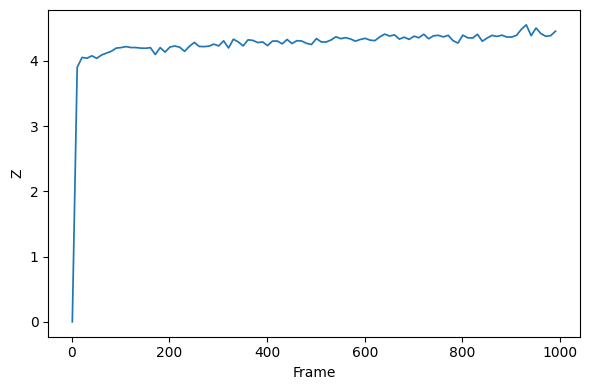

([1,
  11,
  21,
  31,
  41,
  51,
  61,
  71,
  81,
  91,
  101,
  111,
  121,
  131,
  141,
  151,
  161,
  171,
  181,
  191,
  201,
  211,
  221,
  231,
  241,
  251,
  261,
  271,
  281,
  291,
  301,
  311,
  321,
  331,
  341,
  351,
  361,
  371,
  381,
  391,
  401,
  411,
  421,
  431,
  441,
  451,
  461,
  471,
  481,
  491,
  501,
  511,
  521,
  531,
  541,
  551,
  561,
  571,
  581,
  591,
  601,
  611,
  621,
  631,
  641,
  651,
  661,
  671,
  681,
  691,
  701,
  711,
  721,
  731,
  741,
  751,
  761,
  771,
  781,
  791,
  801,
  811,
  821,
  831,
  841,
  851,
  861,
  871,
  881,
  891,
  901,
  911,
  921,
  931,
  941,
  951,
  961,
  971,
  981,
  991],
 array([0.        , 3.89903031, 4.05023946, 4.03848337, 4.07518035,
        4.03630116, 4.08821976, 4.11674944, 4.14503162, 4.1932245 ,
        4.20125179, 4.21629897, 4.20196616, 4.20175867, 4.19312365,
        4.19074556, 4.19993869, 4.09489958, 4.20063794, 4.13193098,
        4.20962305, 4.22585213, 4.2064

In [36]:
determine_N(Frame, loc, NFTP=1000, Gap=10)